In [1]:

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from math import factorial
from scipy.special import gamma
import itertools
import scipy
from scipy.integrate import trapezoid

sns.set_theme(style="whitegrid")

# h - Jacobi Polynomials

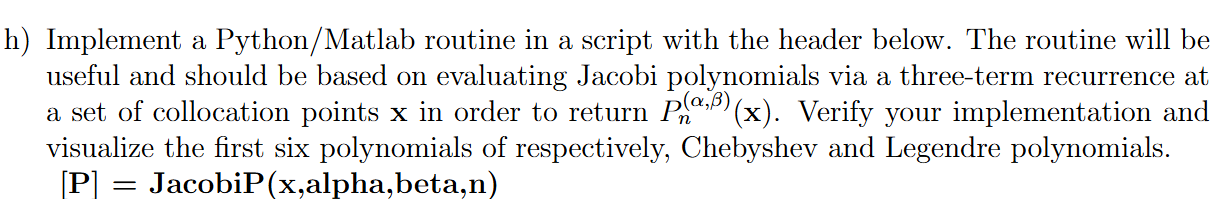

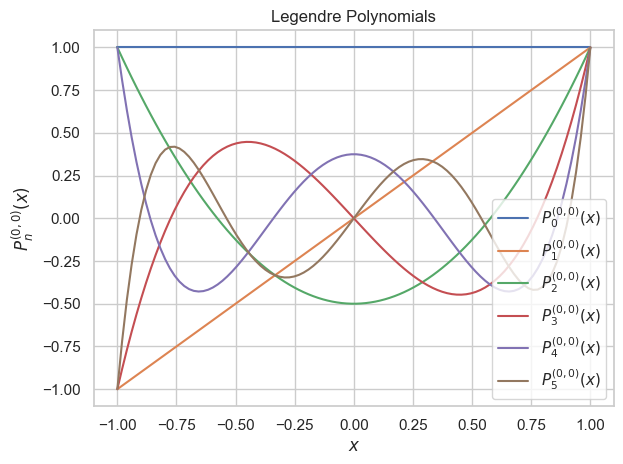

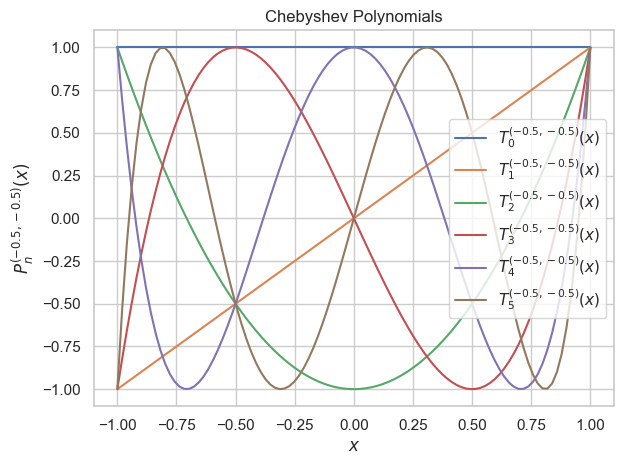

In [2]:
def jacobi_p(x, alpha, beta, n):
    P = np.empty((len(x), n+1))

    P[:, 0] = 1.0
    if n == 0:
        return P

    P[:, 1] = 1/2 * (alpha - beta + (alpha + beta + 2) * x)
    if n == 1:
        return P

    for k in range(1, n):
        a_nm1_n = 2 * (k + alpha) * (k + beta) / ((2 * k + alpha + beta + 1) * (2 * k + alpha + beta))
        a_n_n = (alpha ** 2 - beta ** 2) / ((2 * k + alpha + beta + 2) * (2 * k + alpha + beta))
        a_np1_n = 2 * (k + 1) * (k + alpha + beta + 1) / ((2 * k + alpha + beta + 2) * (2 * k + alpha + beta + 1))

        P[:, k+1] = ((a_n_n + x) * P[:, k] - a_nm1_n * P[:, k-1]) / a_np1_n

    return P

def jacobi_p_normalisation_const(alpha, beta, n):
    return (
        2 ** (alpha + beta + 1)
        * (gamma(n + alpha + 1) * gamma(n + beta + 1))
        / (factorial(n) * (2 * n + alpha + beta + 1) * gamma(n + alpha + beta + 1))
    )

x = np.linspace(-1, 1, 100)

# Legendre
plt.figure()
alpha, beta = 0, 0
for n in [0, 1, 2, 3, 4, 5]:
    P = jacobi_p(x, 0.0, 0.0, n)
    plt.plot(x, P[:, n], label=f'$P_{n}^{{({alpha}, {beta})}}(x)$')

plt.legend()
plt.title('Legendre Polynomials')
plt.xlabel('$x$')
plt.ylabel('$P_n^{(0,0)}(x)$')
plt.tight_layout()

# Chebyshev
plt.figure()
alpha, beta = -0.5, -0.5
for n in [0, 1, 2, 3, 4, 5]:
    P = jacobi_p(x, alpha, beta, n)
    T = (gamma(n+1) * gamma(0.5)) / gamma(n + 0.5) * P
    plt.plot(x, T[:, n], label=f'$T_{n}^{{({alpha}, {beta})}}(x)$')
plt.legend()
plt.title('Chebyshev Polynomials')
plt.xlabel('$x$')
plt.ylabel('$P_n^{(-0.5,-0.5)}(x)$')
plt.tight_layout()


<P_0, P_0> ≈ 1.000000
<P_0, P_1> ≈ 0.000000
<P_0, P_2> ≈ 0.000000
<P_0, P_3> ≈ 0.000000
<P_0, P_4> ≈ 0.000000
<P_0, P_5> ≈ 0.000000
<P_1, P_1> ≈ 1.000000
<P_1, P_2> ≈ 0.000000
<P_1, P_3> ≈ 0.000000
<P_1, P_4> ≈ 0.000000
<P_1, P_5> ≈ 0.000000
<P_2, P_2> ≈ 1.000000
<P_2, P_3> ≈ 0.000000
<P_2, P_4> ≈ 0.000000
<P_2, P_5> ≈ 0.000000
<P_3, P_3> ≈ 1.000000
<P_3, P_4> ≈ 0.000000
<P_3, P_5> ≈ 0.000001
<P_4, P_4> ≈ 1.000001
<P_4, P_5> ≈ 0.000000
<P_5, P_5> ≈ 1.000001


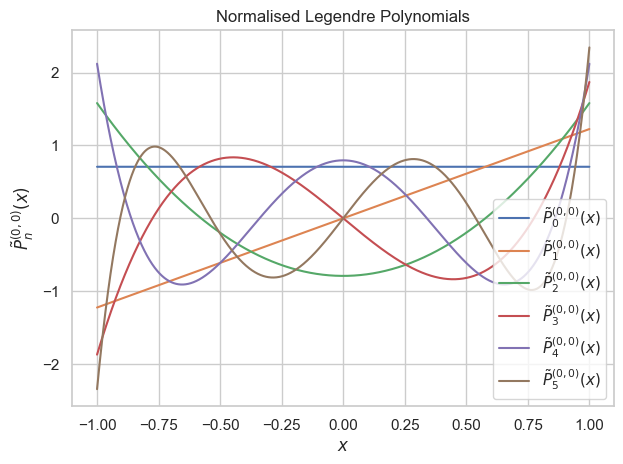

In [3]:
# Check normalised Jacobi polynomials
# Legendre normalised
plt.figure()
alpha, beta = 0, 0
P_orthos = []

x = np.linspace(-1, 1, 10000)

for n in [0, 1, 2, 3, 4, 5]:
    # This computation is quite wasteful since it actually returns all polynomials up to n,
    # but we anyway only use the last one
    # Does not really matter here though
    P = jacobi_p(x, 0.0, 0.0, n)
    norm_coeff = np.sqrt(jacobi_p_normalisation_const(alpha, beta, n))

    P_ortho = P[:, n] / norm_coeff
    P_orthos.append(P_ortho)

    plt.plot(x, P_ortho, label=f'$\\tilde{{P}}_{n}^{{({alpha}, {beta})}}(x)$')

plt.legend()
plt.title('Normalised Legendre Polynomials')
plt.xlabel('$x$')
plt.ylabel('$\\tilde{P}_n^{(0,0)}(x)$')
plt.tight_layout()

# Check for orthonormality using trapezoidal rule for integration
dx = x[1] - x[0]
for i, v1 in enumerate(P_orthos):
    for j, v2 in enumerate(P_orthos):
        if i <= j:
            integral_approx = trapezoid(v1 * v2, dx=dx)
            print(f"<P_{i}, P_{j}> ≈ {integral_approx:.6f}")

            if i == j:
                assert abs(integral_approx - 1.0) < 1e-3
            else:
                assert abs(integral_approx) < 1e-3

# i - Numerical Experiments using Jacobi Polynomials
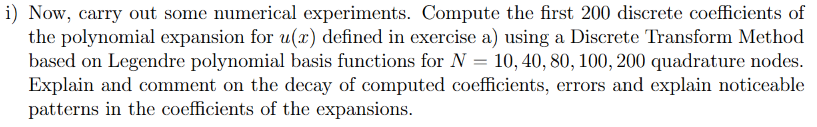

In [4]:
# Gauss-Jacobi quadrature code, adapted from APEK MATLAB code
def JacobiGQ(alpha: float, beta: float, N: int):
    """
    Compute N'th order Gauss-Jacobi quadrature nodes x and weights w
    for weight (1-x)^alpha (1+x)^beta on [-1, 1], with alpha,beta > -1.
    """
    if N == 0:
        x = np.array([-(alpha - beta) / (alpha + beta + 2.0)], dtype=float)
        w = np.array([2.0], dtype=float)  # matches the provided MATLAB code
        return x, w

    J = np.zeros((N + 1, N + 1), dtype=float)
    k = np.arange(0, N + 1, dtype=float)
    h1 = 2.0 * k + alpha + beta

    J[np.arange(N + 1), np.arange(N + 1)] = -0.5 * (alpha**2 - beta**2) / ((h1 + 2.0) * h1)
    if (alpha + beta) < 10.0 * np.finfo(float).eps:
        J[0, 0] = 0.0  # Legendre limit

    kk = np.arange(1, N + 1, dtype=float)
    b = 2.0 / (h1[:-1] + 2.0) * np.sqrt(
        kk * (kk + alpha + beta) * (kk + alpha) * (kk + beta)
        / ((h1[:-1] + 1.0) * (h1[:-1] + 3.0))
    )
    J += np.diag(b, 1)
    J += np.diag(b, -1)
    evals, evecs = np.linalg.eigh(J)
    x = evals  # Gauss nodes
    # Weights from first row of normalized eigenvectors
    # mu0 = integral_{-1}^{1} (1-x)^alpha (1+x)^beta dx
    mu0 = (2.0 ** (alpha + beta + 1.0)) * gamma(alpha + 1.0) * gamma(beta + 1.0) / gamma(alpha + beta + 2.0)
    w = mu0 * (evecs[0, :] ** 2)

    idx = np.argsort(x)
    x, w = x[idx], w[idx]

    return x, w


def JacobiGL(alpha, beta, N):
    x = np.zeros(N+1, dtype=float)
    if N == 1:
        x = np.array([-1, 1])
        return x
    xint, _ = JacobiGQ(alpha + 1, beta + 1, N-2)
    x = np.concatenate((np.array([-1]), xint, np.array([1])))
    return x

C:\Users\jeppe\AppData\Local\Temp\ipykernel_12272\1741127047.py:16: RuntimeWarning: invalid value encountered in divide
  J[np.arange(N + 1), np.arange(N + 1)] = -0.5 * (alpha**2 - beta**2) / ((h1 + 2.0) * h1)


[]

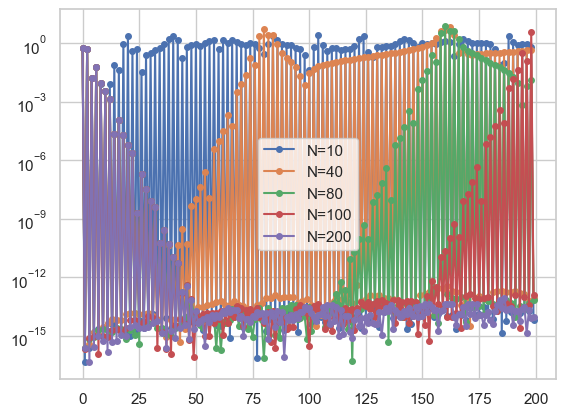

In [5]:
K = 200  # number of discrete coefficients to compute
Ns = [10, 40, 80, 100, 200]  # number of quadrature nodes
alpha = 0.0  # Legendre
beta = 0.0  # Legendre

def u(x):
    # Shift x to match the interval [-1, 1] -> [0, 2]
    x = x - 1.0

    # Scale x to match the interval [0, 2] -> [0, 2π]
    x = x * np.pi

    return 1.0 / (2.0-np.cos(x))  # This now matches a)


forward_transform_data = []
for i, N in enumerate(Ns):
    # Alternatively we can use scipy.special.roots_jacobi
    # We do this check to validate our JacobiGQ implementation,
    # but we will actually be using JacobiGL for the exercise
    x_nodes_gq, w_nodes_gq = JacobiGQ(alpha, beta, N)
    # NOTE: JacobiGQ is set up a bit strangely, so it actually finds roots of N+1th order polynomial
    x_nodes_scipy_gq, w_nodes_scipy_gq = scipy.special.roots_jacobi(N+1, alpha, beta)
    assert np.allclose(x_nodes_gq, x_nodes_scipy_gq)
    assert np.allclose(w_nodes_gq, w_nodes_scipy_gq)

    # Since this worked, we feel confident in JacobiGL as well
    # NOTE:
    # JacobiGL arises from taking the derivative (thus gaining alpha+=1, beta+=1, N-=1)
    # and then evaluating at N-=1 more points, and then adding the endpoints -1 and 1
    # See L2, slide 46

    # x_j
    x_nodes = JacobiGL(alpha, beta, N)

    # Compute weights according to L2, slide 46
    # w_j
    w_nodes = (
        2
        / (N * (N + 1))
        * 1 / ((jacobi_p(x_nodes, alpha, beta, N)**2)[:, N])
    )
    assert w_nodes.shape == (N+1,)

    # See L2, slide 48
    # f(x_j)
    f_nodes = u(x_nodes)
    # ϕ_k(x_j)
    phi_k = jacobi_p(x_nodes, 0.0, 0.0, K)[:, :K]  # All polynomials up to degree K
    # NOTE: These are not normalised. We should probably do that here
    # but in the lectures it is done at the end when computing the coefficients,
    # so we match that treatment here
    assert phi_k.shape == (N+1, K)

    # γ_k
    gamma_k = np.sum(phi_k**2 * w_nodes[:, None], axis=0)
    assert gamma_k.shape == (K,)

    f_k = np.sum(f_nodes[:, None] * phi_k * w_nodes[:, None], axis=0) / gamma_k
    assert f_k.shape == (K,)

    plt.plot(range(K), np.abs(f_k), label=f'N={N}', marker='o', markersize=4)

    forward_transform_data.append({
        "N": N,
        "i": i,
        "x_nodes": x_nodes.copy(),
        "w_nodes": w_nodes,
        "f_nodes": f_nodes,
        "phi_k": phi_k,
        "gamma_k": gamma_k,
        "f_k": f_k,
    })

plt.legend()
plt.semilogy()
    # plt.semilogy(range(K), np.abs(coeffs), label=f'N={N}', marker='o', markersize=4)
# To implement:
# Root finding method: use Newton-Raphson (L2, slide 38)


# A method in MATLAB seems to exist (and in scipy as well, I think: scipy.special.roots_jacobi)
# If we cannot directly use this, use it to check

Text(0.5, 1.0, 'Reconstruction error')

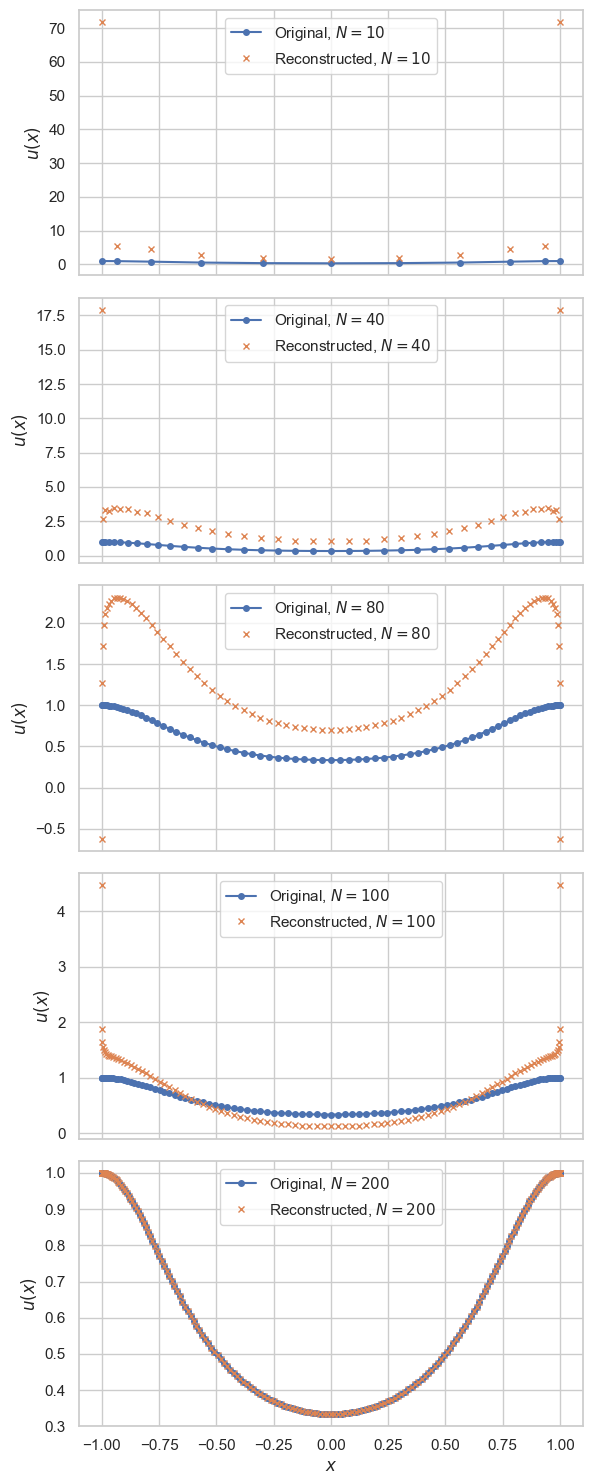

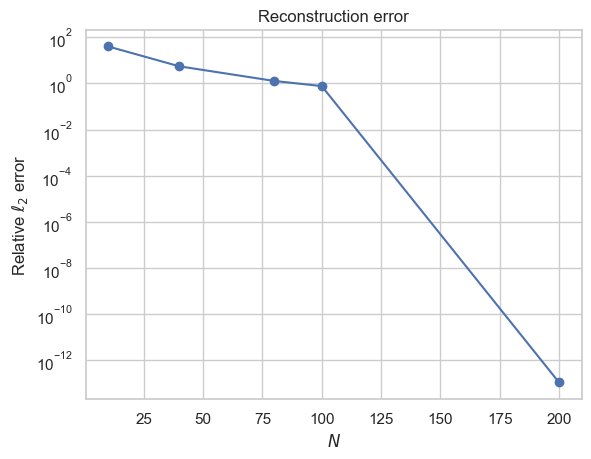

In [6]:
# Test reconstruction using inverse DPT
fig, axes = plt.subplots(len(Ns), 1, figsize=(6, 3*len(Ns)), sharex=True)
errors = []
for ax, datum in zip(axes, forward_transform_data):
    N = datum["N"]
    # Inverse DPT
    f_nodes_reconstructed = datum["f_k"] @ datum["phi_k"].T
    assert f_nodes_reconstructed.shape == (datum["N"]+1,)

    ax.plot(datum["x_nodes"], datum["f_nodes"], '-o', label=f'Original, $N={N}$', markersize=4)
    ax.plot(datum["x_nodes"], f_nodes_reconstructed, 'x', label=f'Reconstructed, $N={N}$', markersize=4)
    ax.legend(loc="upper center")
    ax.set_ylabel('$u(x)$')
    if N == Ns[-1]:
        ax.set_xlabel('$x$')

    error = np.linalg.norm(datum["f_nodes"] - f_nodes_reconstructed, ord=2) / np.linalg.norm(datum["f_nodes"], ord=2)
    errors.append(error)

plt.tight_layout()

# Check errors
plt.figure()
plt.semilogy(Ns, errors, '-o')
plt.xlabel('$N$')
plt.ylabel('Relative $ℓ_2$ error')
plt.title('Reconstruction error')

# Looks reasonable


# j - Vandermonde Matrix
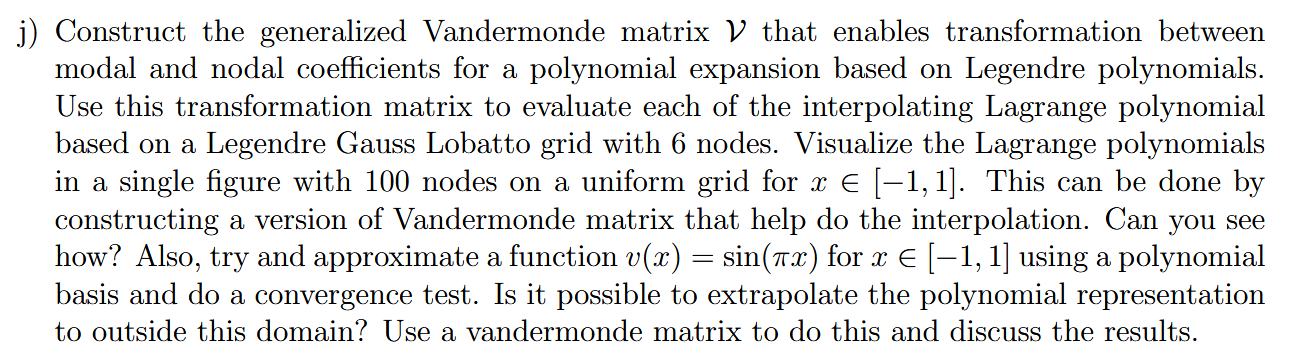

# k - Jacobi Derivatives

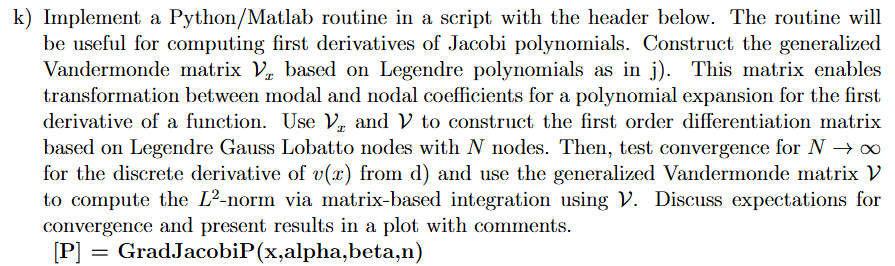

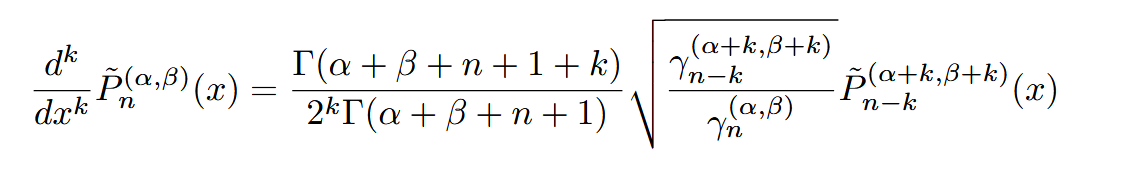

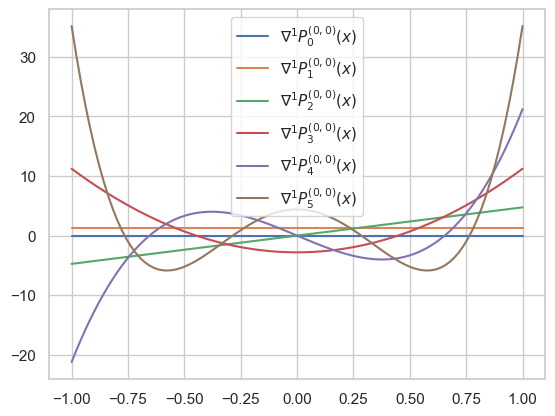

In [7]:
def grad_orthonormal_jacobi_p(x, alpha, beta, n, k):
    if n == 0:
        return np.zeros_like(x)

    # if n == 1:
    #     return np.ones_like(x) * 1/2 * (alpha - beta + (alpha + beta + 2))

    ortho_P = 1 / np.sqrt(jacobi_p_normalisation_const(alpha+k, beta+k, n-k)) * jacobi_p(x, alpha + k, beta + k, n - k)[:, n - k]
    # plt.plot(x, ortho_P)
    return (
        1
        * gamma(alpha + beta + n + 1 + k)
        / (2 ** k * gamma(alpha + beta + n + 1))
        * np.sqrt(
            jacobi_p_normalisation_const(alpha + k, beta + k, n - k)
            / jacobi_p_normalisation_const(alpha, beta, n)
        )
        * ortho_P
    )

x = np.linspace(-1, 1, 100)
plt.figure()
alpha, beta = 0, 0
P_grads = []
for n in [0, 1, 2, 3, 4, 5]:

    for k in [1]:
        P_grad = grad_orthonormal_jacobi_p(x, alpha, beta, n, k)
        plt.plot(x, P_grad, label=f'$\\nabla^{{{k}}} P_{{{n}}}^{{({alpha}, {beta})}}(x)$')
        P_grads.append(P_grad)
plt.legend()


